In [12]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
random.seed(10)

In [101]:
print("Question 1: Y = tau*T+X@beta0+err  Simple example: Estimation of Test score and level of education; however,the hours spent on studying can also affect the test score, and level of education is jue one factor ")

Question 1: Y = tau*T+X@beta0+err  Simple example: Estimation of Test score and level of education; however,the hours spent on studying can also affect the test score, and level of education is jue one factor 


In [28]:
print("Question 1")

Question 1


In [13]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import networkx as net
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
style.use("fivethirtyeight")

In [14]:
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])
def fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX=False):
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)            
        elif flagX==1:
            # use the right covariates in regression
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==2:
            # use some of the right covariates and some "wrong" ones
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs1 = X[:,:np.int(p0/2)]
            Xobs2 = X[:,-np.int(p0/2):]
            covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)

In [15]:
def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
    
    nvar = p+2 
    corr = 0.5 

    if conf==False:
        conf_mult = 0 
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) 
    C = allX[:,1].reshape([N,1]) 
    X = allX[:,2:] 
    
    T = fn_randomize_treatment(N) 
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)

In [31]:
tau = 8
corr = .5
conf=False
p = 8
p0 = 0 
Nrange = range(10,100,2)
N=500
flagX=1
Y,Z,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|█████████████████████████████████████████| 45/45 [00:00<00:00, 1554.56it/s]


{'Level of education': {'Test score': {'weight': 0.5}}, 'Test score': {}, 'Numver of hours spent studying': {'Test score': {'weight': 5}}}


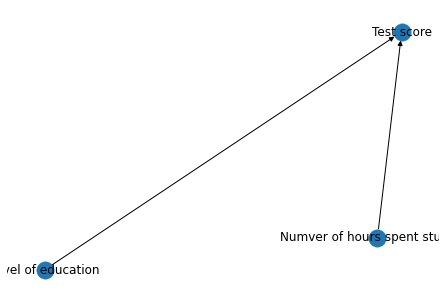

In [17]:
G = net.DiGraph()
    

G.add_edge('Level of education','Test score', weight=0.5)
G.add_edge('Numver of hours spent studying','Test score',weight=5)
print(G.adj)
net.draw(G,with_labels=True)
plt.show()


In [34]:
data = np.concatenate([Y,Z,X],axis=1)
data = pd.DataFrame(data)
data.to_csv('Question 1.csv')

In [18]:
def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

In [29]:
print("Without control covariate")

Without control covariate


In [22]:
N = 100
Yexp,T = fn_generate_data(tau,N,10,0,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]

In [23]:
tauhat,se_tauhat

(7.852021732682725, 0.21662938087970707)

In [35]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,10,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:09<00:00, 213.35it/s]


In [36]:
def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

In [37]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')
    

N=100: bias=-0.0003704613232615026, RMSE=0.2012859886038055, size=0.0475
N=1000: bias=-0.002195373365733817, RMSE=0.061193177160304535, size=0.046


In [30]:
print("Control for all covariate")

Control for all covariate


In [41]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:09<00:00, 208.23it/s]


In [42]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.0005684899113411487, RMSE=0.14244466888324164, size=0.058
N=1000: bias=0.0001353723073993991, RMSE=0.04475790595780382, size=0.05


In [44]:
print("Question 2")

Question 2


In [102]:
print("Question 2: Y=8*T+0.6*C+error T=0.6 cofounder + error   For example: If we want to estimate the relationship between smoking and lung cancer,age has a relationship with smoking and lung cancer" )

Question 2: Y=8*T+0.6*C+error T=0.6 cofounder + error   For example: If we want to estimate the relationship between smoking and lung cancer,age has a relationship with smoking and lung cancer


In [70]:
def fn_generate_cof_data(tau,N,p,corr,conf = True):
   
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+0.6*C+err
    return (Yab,T,C)
    

In [80]:
tau = 8
corr = .5
conf=True
p = 8 
Nrange = range(10,100,2)
N=1000
Y,T,C = fn_generate_cof_data(tau,N,p,corr,conf)

In [82]:
data = np.concatenate([Y,T,C],axis=1)
data = pd.DataFrame(data)
data.to_csv('Question 2.csv')

{'Treatment': {'Outcome': {'weight': 0.5}}, 'Outcome': {}, 'Cofounder': {'Treatment': {'weight': 5}, 'Outcome': {'weight': 5}}}


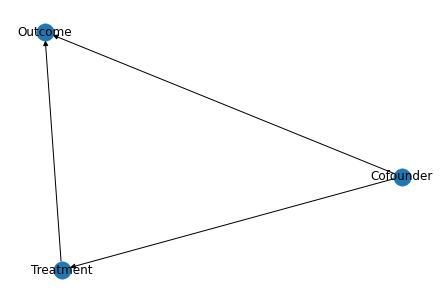

In [74]:
G = net.DiGraph()
    

G.add_edge('Treatment', 'Outcome',weight=0.5)
G.add_edge('Cofounder','Treatment',weight=5)
G.add_edge('Cofounder','Outcome',weight=5)

print(G.adj)
net.draw(G,with_labels=True)
plt.show()


In [79]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,C = fn_generate_cof_data(tau,N,p,corr)
        covars = np.concatenate([T],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:09<00:00, 205.97it/s]


In [83]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.002863845299535968, RMSE=0.1666248488304704, size=0.0615
N=1000: bias=-0.0007268183791961431, RMSE=0.05136143020258387, size=0.0445


In [84]:
print("Include Cofounder")

Include Cofounder


In [86]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,C = fn_generate_cof_data(tau,N,p,corr)
        covars = np.concatenate([T,C],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:10<00:00, 190.88it/s]


In [87]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')


N=100: bias=0.0001786390307257224, RMSE=0.14309535955717043, size=0.059
N=1000: bias=0.0007857272163508169, RMSE=0.04406310635741575, size=0.044


In [88]:
print("Question 3")

Question 3


In [ ]:
print("Question 3: For example, evaluating the effectiveness of job training program, people who take part in this program may have more diligent, which c")

In [89]:
def fn_generate_selection_data(tau,N,p,corr):

    nvar = p+1 
    corr = 0.8 
 
    allX = fn_generate_multnorm(N,corr,nvar)
    T = fn_randomize_treatment(N) 
    err = np.random.normal(0,1,[N,1])
    U = np.random.normal(0,1,[N,1])
    Y = tau*T+err
    S = 2*T+0.8*Y+U

    return (Y,T,S)

In [91]:
tau = 4
corr = 0.8
p = 2
N = 1000
Y,T,S = fn_generate_selection_data(tau,N,p,corr)

In [ ]:
data = np.concatenate([Y,Z,X],axis=1)
data = pd.DataFrame(data)
data.to_csv('Question 3.csv')

{'Treatment': {'Outcome': {'weight': 0.5}, 'Selection Bias': {'weight': 5}}, 'Outcome': {'Selection Bias': {'weight': 5}}, 'Selection Bias': {}}


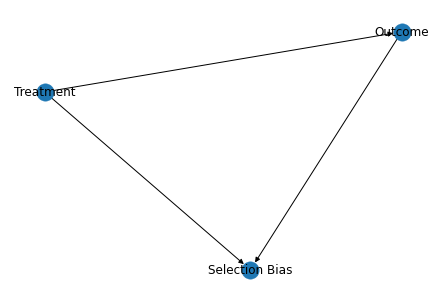

In [93]:
G = net.DiGraph()
    

G.add_edge('Treatment', 'Outcome',weight=0.5)
G.add_edge('Outcome','Selection Bias',weight=5)
G.add_edge('Treatment','Selection Bias',weight=5)

print(G.adj)
net.draw(G,with_labels=True)
plt.show()


In [95]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,Z = fn_generate_selection_data(tau,N,p,corr)   
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }


100%|██████████████████████████████████████| 2000/2000 [00:09<00:00, 220.48it/s]


In [96]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.006478455325668335, RMSE=0.19674091949438713, size=0.05
N=1000: bias=-0.0017926478950117764, RMSE=0.06386240781299542, size=0.0525


In [97]:
print("Control for selection bias")

Control for selection bias


In [99]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,Z = fn_generate_selection_data(tau,N,p,corr)
        covars = np.concatenate([T,Z],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }


100%|██████████████████████████████████████| 2000/2000 [00:09<00:00, 211.84it/s]


In [100]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-2.5393179807177266, RMSE=2.562341791612058, size=1.0
N=1000: bias=-2.5344477437030637, RMSE=2.536664261293932, size=1.0
